In [1]:
import pandas as pd
from pathlib import Path

In [ ]:
basic_directory = Path.cwd()                            # directory of the file - folder "code"
data_directory = basic_directory.parent / "data"        # go one level up and choose folder "data"

# It's a common convention to add a _df suffix to a variable name to indicate it's a DataFrame.
flights_df  = pd.read_csv(data_directory / "flights.csv")
airlines_df = pd.read_csv(data_directory / "airlines.csv")
airports_df = pd.read_csv(data_directory / "airports.csv")
planes_df   = pd.read_csv(data_directory / "planes.csv")
weather_df  = pd.read_csv(data_directory / "weather.csv")

# Convert to datetime++
flights_df['time_hour'] = pd.to_datetime(flights_df['time_hour'])
weather_df['time_hour'] = pd.to_datetime(weather_df['time_hour'])

# Remove timezone
weather_df['time_hour'] = weather_df['time_hour'].dt.tz_localize(None)

'''
Convert the 'time_hour' column in flights_df and weather_df to datetime64[ns] type, as it was 'object'.
This was necessary because a merge on date/time types was not possible otherwise.

The dtype for flights_df was datetime64[ns], while for weather_df it was datetime64[ns, UTC]. Removed the UTC timezone.
'''

"\nConvert the 'time_hour' column in flights_df and weather_df to datetime64[ns] type, as it was 'object'.\nThis was necessary because a merge on date/time types was not possible otherwise.\n\nThe dtype for flights_df was datetime64[ns], while for weather_df it was datetime64[ns, UTC]. Removed the UTC timezone.\n"

In [6]:
# How many flights were there in the 5th month

flights_in_may = airlines_df.merge(flights_df, on='carrier')
flights_in_may = flights_in_may[flights_in_may["month"]==5]
'''
flights_in_may = flights_in_may[["name", "month"]]  # выбор колонок - Оно типа надо, но на будущее
Но в случае с группировкой .groupby(...).size().reset_index() выборка колонок делается автоматически: 
в результате остаются ключ группировки + агрегат.
'''
result = (
    flights_in_may
    .groupby('name')
    .size()                         # Corresponds to COUNT(*)
    .reset_index(name="count")      # Convert the series to a DataFrame column
    .sort_values('count', ascending=False)
)

print(result)

                           name  count
5      ExpressJet Airlines Inc.    143
12        United Air Lines Inc.    131
8               JetBlue Airways    121
2          Delta Air Lines Inc.    113
1        American Airlines Inc.     91
4                     Envoy Air     65
11              US Airways Inc.     50
3             Endeavor Air Inc.     43
10       Southwest Airlines Co.     27
13               Virgin America     21
0   AirTran Airways Corporation      8
9            Mesa Airlines Inc.      3
6        Frontier Airlines Inc.      1
7        Hawaiian Airlines Inc.      1


**Key Finding:**  
ExpressJet Airlines Inc. had the most flights in May (143), with United Air Lines Inc. (131) and JetBlue Airways (121) close behind.

In [5]:
# Which company has the fewest delays (arr_delay <= 0)

minimal_delay = airlines_df.merge(flights_df, on='carrier')
minimal_delay = minimal_delay[minimal_delay["arr_delay"] <= 0]

result = (
    minimal_delay
    .groupby('name')['arr_delay']
    .count()                        # Corresponds to COUNT(dep_delay)
    .reset_index(name='not_delay')  # Column name as in the SQL query
    .sort_values('not_delay', ascending=False)
)

print(result)

                           name  not_delay
13        United Air Lines Inc.       1051
3          Delta Air Lines Inc.        925
9               JetBlue Airways        887
6      ExpressJet Airlines Inc.        800
2        American Airlines Inc.        630
5                     Envoy Air        375
12              US Airways Inc.        364
4             Endeavor Air Inc.        281
11       Southwest Airlines Co.        197
14               Virgin America        104
0   AirTran Airways Corporation         26
1          Alaska Airlines Inc.         18
10           Mesa Airlines Inc.         14
8        Hawaiian Airlines Inc.         12
7        Frontier Airlines Inc.         10


**Key Finding:**  
United Air Lines Inc. leads in absolute numbers (1,051), followed by Delta Air Lines Inc. (925)

In [25]:
# Count the total number of flights for each airline.
# Series
all_flights = airlines_df.merge(flights_df, on='carrier')

result = (
    all_flights
    .groupby('name')
    .size()
    .sort_values(ascending=False)
)

print(result)

'''
# DataFrame

all_flights = (
    all_flights
    .groupby('name')
    .size()
    .reset_index(name='num_flights')    # converts Series to DataFrame and names the column 
    .sort_values('num_flights', ascending=False)
)
'''

name
United Air Lines Inc.          1741
ExpressJet Airlines Inc.       1643
JetBlue Airways                1636
Delta Air Lines Inc.           1425
American Airlines Inc.          958
Envoy Air                       769
US Airways Inc.                 592
Endeavor Air Inc.               521
Southwest Airlines Co.          386
Virgin America                  150
AirTran Airways Corporation      97
Alaska Airlines Inc.             23
Frontier Airlines Inc.           23
Mesa Airlines Inc.               20
Hawaiian Airlines Inc.           15
SkyWest Airlines Inc.             1
dtype: int64


"\n# DataFrame\n\nall_flights = (\n    all_flights\n    .groupby('name')\n    .size()\n    .reset_index(name='num_flights')    # converts Series to DataFrame and names the column \n    .sort_values('num_flights', ascending=False)\n)\n"

**Key Finding:**  
United Air Lines Inc. is the most active carrier with 1,741 flights, followed by ExpressJet Airlines Inc. (1,643) and JetBlue Airways (1,636)

**Insight:**  
Throughout the year, the Top 3 are almost equal (the difference is 6.4%), which indicates balanced competition rather than a monopoly

In [7]:
# How weather affected delays. Lower 'visib' means worse visibility

weather_impact = flights_df.merge(weather_df, on=['time_hour', 'origin'])
weather_impact = weather_impact[weather_impact['dep_delay']>0]

result = (
    weather_impact
    .groupby('visib')
    .agg(
        avg_delay=('dep_delay', 'mean'),            # AVG(dep_delay)
        number_of_flights=('dep_delay', 'count')    # COUNT(*)
    )
    .reset_index() 
    .sort_values('visib', ascending=False)
)

print(result)

# Surprisingly, the correlation is barely noticeable*/;

    visib   avg_delay  number_of_flights
19  10.00   36.826693               3012
18   9.00   46.164474                152
17   8.00   56.980198                101
16   7.00   39.905660                106
15   6.00   50.333333                 75
14   5.00   62.370370                 81
13   4.00   58.121951                 41
12   3.00   48.816667                 60
11   2.50   63.205128                 39
10   2.00   38.913043                 46
9    1.75  113.500000                  4
8    1.50   69.971429                 35
7    1.25   66.714286                  7
6    1.00   56.947368                 19
5    0.75   47.750000                  4
4    0.50   58.611111                 18
3    0.25   28.000000                 18
2    0.12   98.666667                 12
1    0.06   68.000000                  1
0    0.00   52.800000                  5


**Key Finding:**  
The data shows a weak correlation. Surprisingly, the highest average delay (113.50 min) occurs at a relatively good visibility of 9 miles, which means delays are caused by factors other than just visibility

                           name  year_y
8        Hawaiian Airlines Inc.  2012.0
11        SkyWest Airlines Inc.  2010.0
1          Alaska Airlines Inc.  2009.0
15               Virgin America  2009.0
7        Frontier Airlines Inc.  2008.0
9               JetBlue Airways  2007.0
4             Endeavor Air Inc.  2006.0
10           Mesa Airlines Inc.  2004.0
13              US Airways Inc.  2004.0
12       Southwest Airlines Co.  2004.0
6      ExpressJet Airlines Inc.  2002.0
0   AirTran Airways Corporation  2001.0
14        United Air Lines Inc.  2000.0
3          Delta Air Lines Inc.  1997.0
2        American Airlines Inc.  1987.0
5                     Envoy Air  1978.0


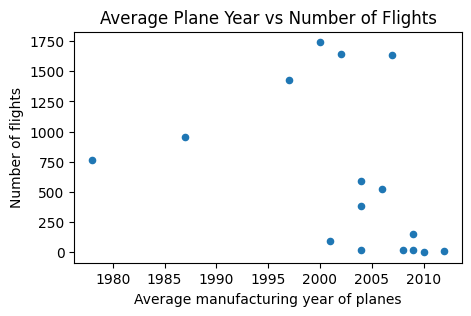

In [ ]:
# Average age of planes for each airline

flights_with_airlines = flights_df.merge(airlines_df, on='carrier')
flights_per_company = flights_with_airlines.merge(planes_df, on='tailnum')
avg_age = (
    flights_per_company
    .groupby('name')['year_y']  # 'year_y' is used as the manufacturing year of the plane.
    .mean()                     # The flights_df also has a 'year' column for the flight's year.
    .round(0)                   # Rounds the average year.
    .reset_index()
    .sort_values('year_y', ascending=False)
)

all_flights = airlines_df.merge(flights_df, on='carrier')

# Series without column name
all_flights = (
    all_flights
    .groupby('name')
    .size()
    .reset_index(name='num_flights')    # converts Series to DataFrame and names the column 
    .sort_values('num_flights', ascending=False)
)

combined = avg_age.merge(all_flights, on='name', how='inner')

combined.plot.scatter(
    x='year_y',
    y='num_flights',
    title='Average Plane Year vs Number of Flights',
    xlabel='Average manufacturing year of planes',
    ylabel='Number of flights',
    figsize=(5, 3)
)


print(avg_age)

**Description:**
The first part (avg_age) of the code shows the average age of aircraft in each company. The top three companies in terms of number of flights were not among the top in terms of average age. I decided to create a visualization to see the number of flights per company and the average age of aircraft together.

**Key Finding:**  
The visualization shows that the newest aircraft belong to companies with the lowest number of flights. This most likely indicates that these companies are young (as of 2013, when the statistics were compiled).